In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kimbbaro","key":"0eee4ddbd0a80636c2a3f8146af07993"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c porto-seguro-safe-driver-prediction

 95% 73.0M/76.5M [00:00<00:00, 92.9MB/s]
100% 76.5M/76.5M [00:00<00:00, 94.9MB/s]


In [ ]:
!unzip /content/porto-seguro-safe-driver-prediction.zip

Archive:  /content/porto-seguro-safe-driver-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import VarianceThreshold, SelectFromModel

from sklearn.model_selection import StratifiedKFold, cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option("display.max_columns", 100)

VarianceThreshold는 분산이 일정 수준 이하인 feature를 제거해주는 데 사용되는 scikit-learn 라이브러리의 함수입니다. 이를 통해 데이터에서 분산이 낮은 feature는 모델링에 유용하지 않을 가능성이 높기 때문에 제거하여 모델의 성능을 개선할 수 있습니다.

SelectFromModel은 지정된 estimator 모델을 이용하여 feature selection을 수행하는 데 사용되는 scikit-learn 라이브러리의 함수입니다. 지정된 모델에서 feature importance를 계산한 후, 미리 지정된 임계치 이상의 feature만 선택하여 반환합니다. 이를 통해 feature selection 과정에서 모델의 성능을 유지하면서 feature 수를 줄일 수 있습니다.

In [ ]:
trainset = pd.read_csv("/content/train.csv")
testset = pd.read_csv("/content/test.csv")

In [ ]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [ ]:
print("Train dataset (rows, cols):",trainset.shape, "\nTest dataset (rows, cols):",testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


In [ ]:
print("Columns in train and not in test dataset:",set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset: {'target'}


In [ ]:
data = []
for feature in trainset.columns:
  if feature == "target":
    use = "target"
  elif feature == "id":
    use = 'id'
  else:
    use = "input"

  if 'bin' in feature or feature == "target":
    type = 'binary'
  elif "cat" in feature or feature == 'id':
    type = "categorical"
  elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
    type = "real"
  elif trainset[feature].dtype == int:
    type = 'integer'

  preserve = True
  if feature == "id":
    preserve = False
  dtype = trainset[feature].dtype

  category = 'none'

  if 'ind' in feature:
    category = "indivisual"
  elif "reg" in feature:
    category = "registration"
  elif 'car' in feature:
    category = "car"
  elif "calc" in feature:
    category = "calculated"

  feature_dictionary = {
      "varname" : feature,
      "use" : use,
      "type" : type,
      "preserve" : preserve,
      "dtype" : dtype,
      "category" : category
  }

  data.append(feature_dictionary)

metadata = pd.DataFrame(data, columns = ["varname", "use", "type", "preserve", "dtype", "category"])
metadata.set_index("varname", inplace = True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,indivisual
ps_ind_02_cat,input,categorical,True,int64,indivisual
ps_ind_03,input,integer,True,int64,indivisual
ps_ind_04_cat,input,categorical,True,int64,indivisual
ps_ind_05_cat,input,categorical,True,int64,indivisual
ps_ind_06_bin,input,binary,True,int64,indivisual
ps_ind_07_bin,input,binary,True,int64,indivisual


In [ ]:
metadata[(metadata.type == "categorical") & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [ ]:
pd.DataFrame({"count" : metadata.groupby(['category'])["category"].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,indivisual,18
3,none,2
4,registration,3


In [ ]:
pd.DataFrame({"count" : metadata.groupby(["use", "type"])["use"].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


<Figure size 640x480 with 0 Axes>

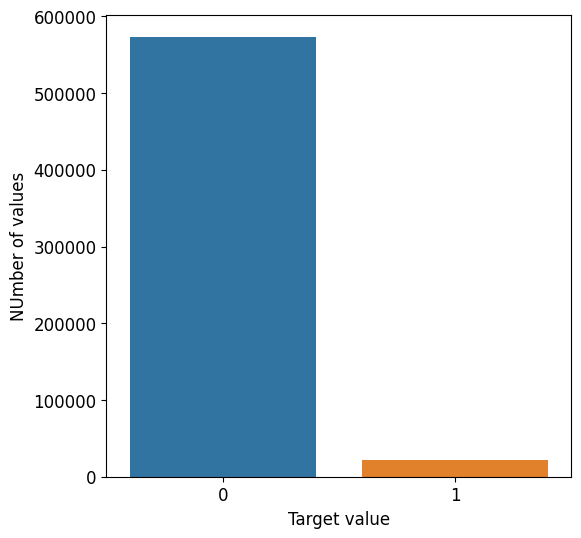

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize = (6,6))
x = trainset["target"].value_counts().index.values
y = trainset["target"].value_counts().values

sns.barplot(ax=ax, x=x, y=y)
plt.ylabel("NUmber of values", fontsize = 12)
plt.xlabel("Target value", fontsize = 12)
plt.tick_params(axis = "both", which = "major", labelsize = 12)
plt.show()

In [ ]:
variable  = metadata[(metadata.type =="real") & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [ ]:
(pow(trainset["ps_car_12"] * 10, 2)).head(10) #10곱하고 제곱

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [ ]:
(pow(trainset["ps_car_15"] * 10, 2)).head(10) #10곱하고 제곱

0    1300.0
1     600.0
2    1100.0
3     400.0
4     400.0
5     900.0
6    1000.0
7    1100.0
8     800.0
9    1300.0
Name: ps_car_15, dtype: float64

특징들 간에 상관관게

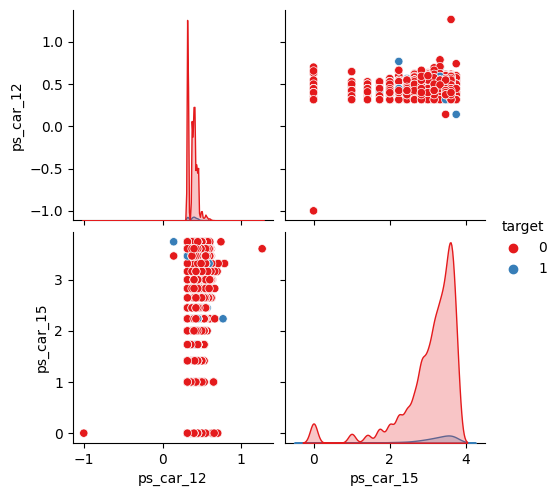

In [ ]:
sample = trainset.sample(frac=0.05)
var = ["ps_car_12", "ps_car_15", "target"]
sample = sample[var]
sns.pairplot(sample, hue = "target", palette = "Set1", diag_kind = "kde")
plt.show()

plt.subplot(3,4,i)는 3행 4열의 서브플롯 중 i번째 서브플롯을 선택하는 함수입니다.

<ipython-input-32-34c37a5a4dbe>:13: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t1[feature], bw = 0.5, label = "target = 1")
<ipython-input-32-34c37a5a4dbe>:14: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t0[feature], bw = 0.5, label = "target = 0")
<ipython-input-32-34c37a5a4dbe>:13: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t1[feature], bw = 0.5, label = "target = 1")
<ipython-input-32-34c37a5

<Figure size 640x480 with 0 Axes>

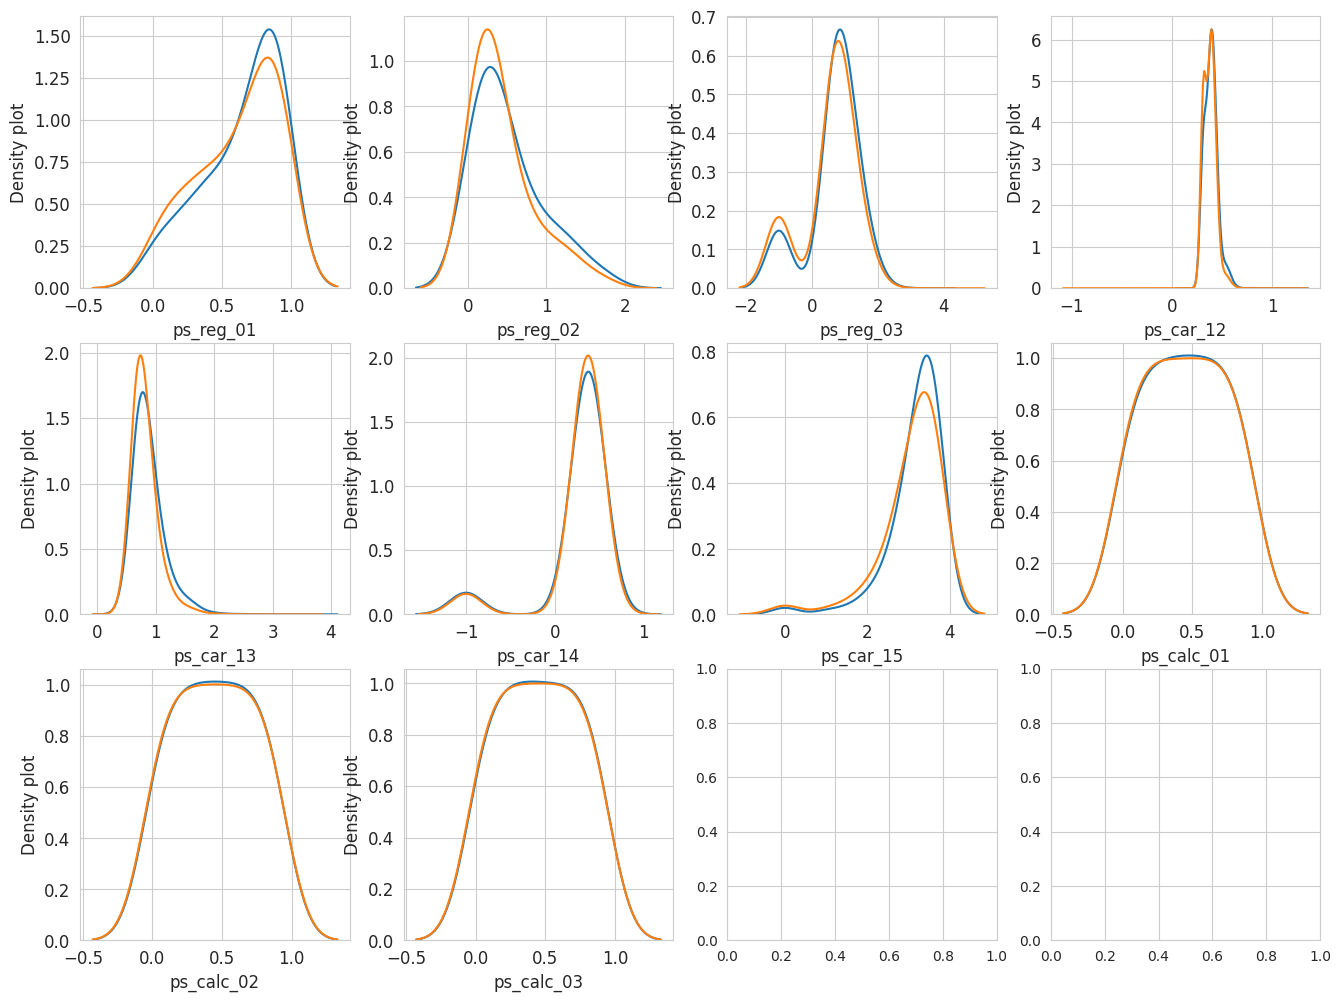

In [ ]:
var = metadata[(metadata.type == "real") & (metadata.preserve)].index
i = 0 
t1 = trainset.loc[trainset['target'] !=0]
t0 = trainset.loc[trainset['target'] ==0]

sns.set_style("whitegrid")
plt.figure()
fig, ax= plt.subplots(3,4,figsize = (16,12))

for feature in var:
  i +=1
  plt.subplot(3,4,i)
  sns.kdeplot(t1[feature], bw = 0.5, label = "target = 1")
  sns.kdeplot(t0[feature], bw = 0.5, label = "target = 0")
  plt.ylabel("Density plot", fontsize = 12)
  plt.xlabel(feature, fontsize = 12)
  locs, labels = plt.xticks()
  plt.tick_params(axis = "both", which = "major", labelsize =12)
plt.show();


cmap은 색상 맵(color map)으로, 데이터에 따라 색상을 지정하는 데 사용됩니다. 여기에서는 sns.diverging_palette 함수를 사용하여 색상 맵을 생성합니다. 이 함수는 시작 색상과 끝 색상, 그리고 중간 색상을 정의할 수 있습니다. as_cmap = True 옵션을 사용하여 생성된 색상 맵이 matplotlib의 colormap object로 반환되도록 합니다. 이렇게 생성된 색상 맵은 heatmap과 같은 시각화에서 사용될 수 있습니다.

correlations: 상관관계 행렬을 의미하는 데이터프레임입니다.

cmap: 색상 맵을 설정하는 변수입니다. 이 코드에서는 파란색-흰색-빨간색으로 이루어진 diverging 팔레트를 사용합니다.

vmax: 색상의 밝기를 조절하는 변수 중 최대값입니다. 여기서는 1로 설정되어 있습니다.

center: 색상의 중심값을 설정하는 변수입니다. 이 코드에서는 0으로 설정되어 있습니다.

fmt: 히트맵 내에 표시되는 값의 형식을 설정하는 변수입니다. 이 코드에서는 소수점 아래 2자리까지 표시하도록 ".2f"로 설정되어 있습니다.

square: 히트맵의 모양을 정사각형으로 설정하는 변수입니다.
linewidth: 히트맵 내의 각 칸의 경계선 두께를 설정하는 변수입니다.

annot: 히트맵 내에 상관관계 값 자체를 표시할 것인지 여부를 설정하는 변수입니다. True로 설정되어 있습니다.

cbar_kws: 컬러바의 속성을 설정하는 변수입니다. 이 코드에서는 컬러바의 크기를 축소하는 "shrink" 속성을 0.75로 설정합니다.

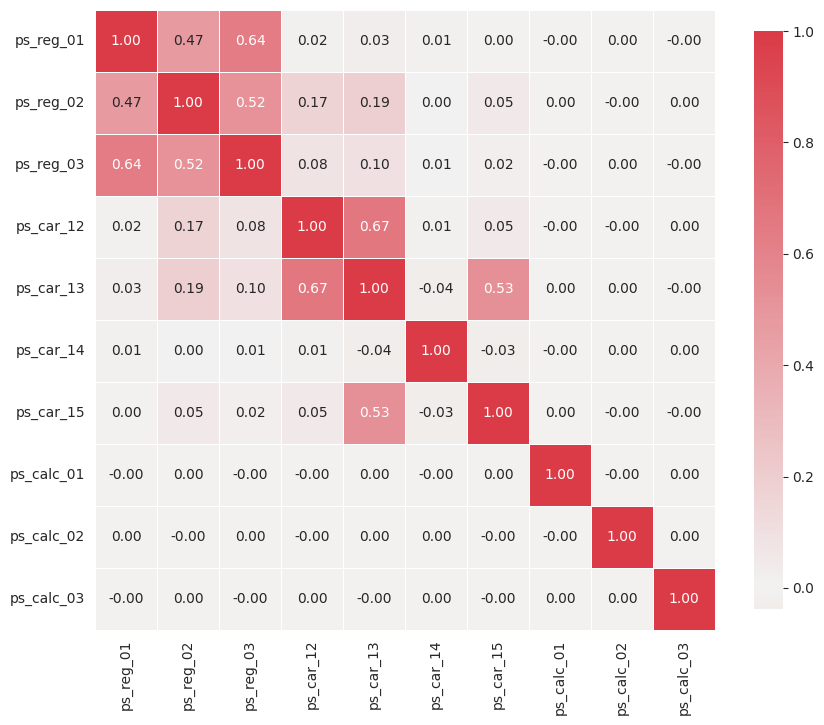

In [ ]:
def corr_heatmap(var):
  correlations = trainset[var].corr()

  cmap = sns.diverging_palette(50, 10, as_cmap = True)

  fig,ax = plt.subplots(figsize = (10,10))
  sns.heatmap(correlations, cmap = cmap, vmax = 1.0, center= 0 ,fmt=".2f",
              square = True, linewidth = .5, annot=True, cbar_kws = {"shrink" : .75})
  plt.show()

var = metadata[(metadata.type == "real") & (metadata.preserve)].index
corr_heatmap(var)

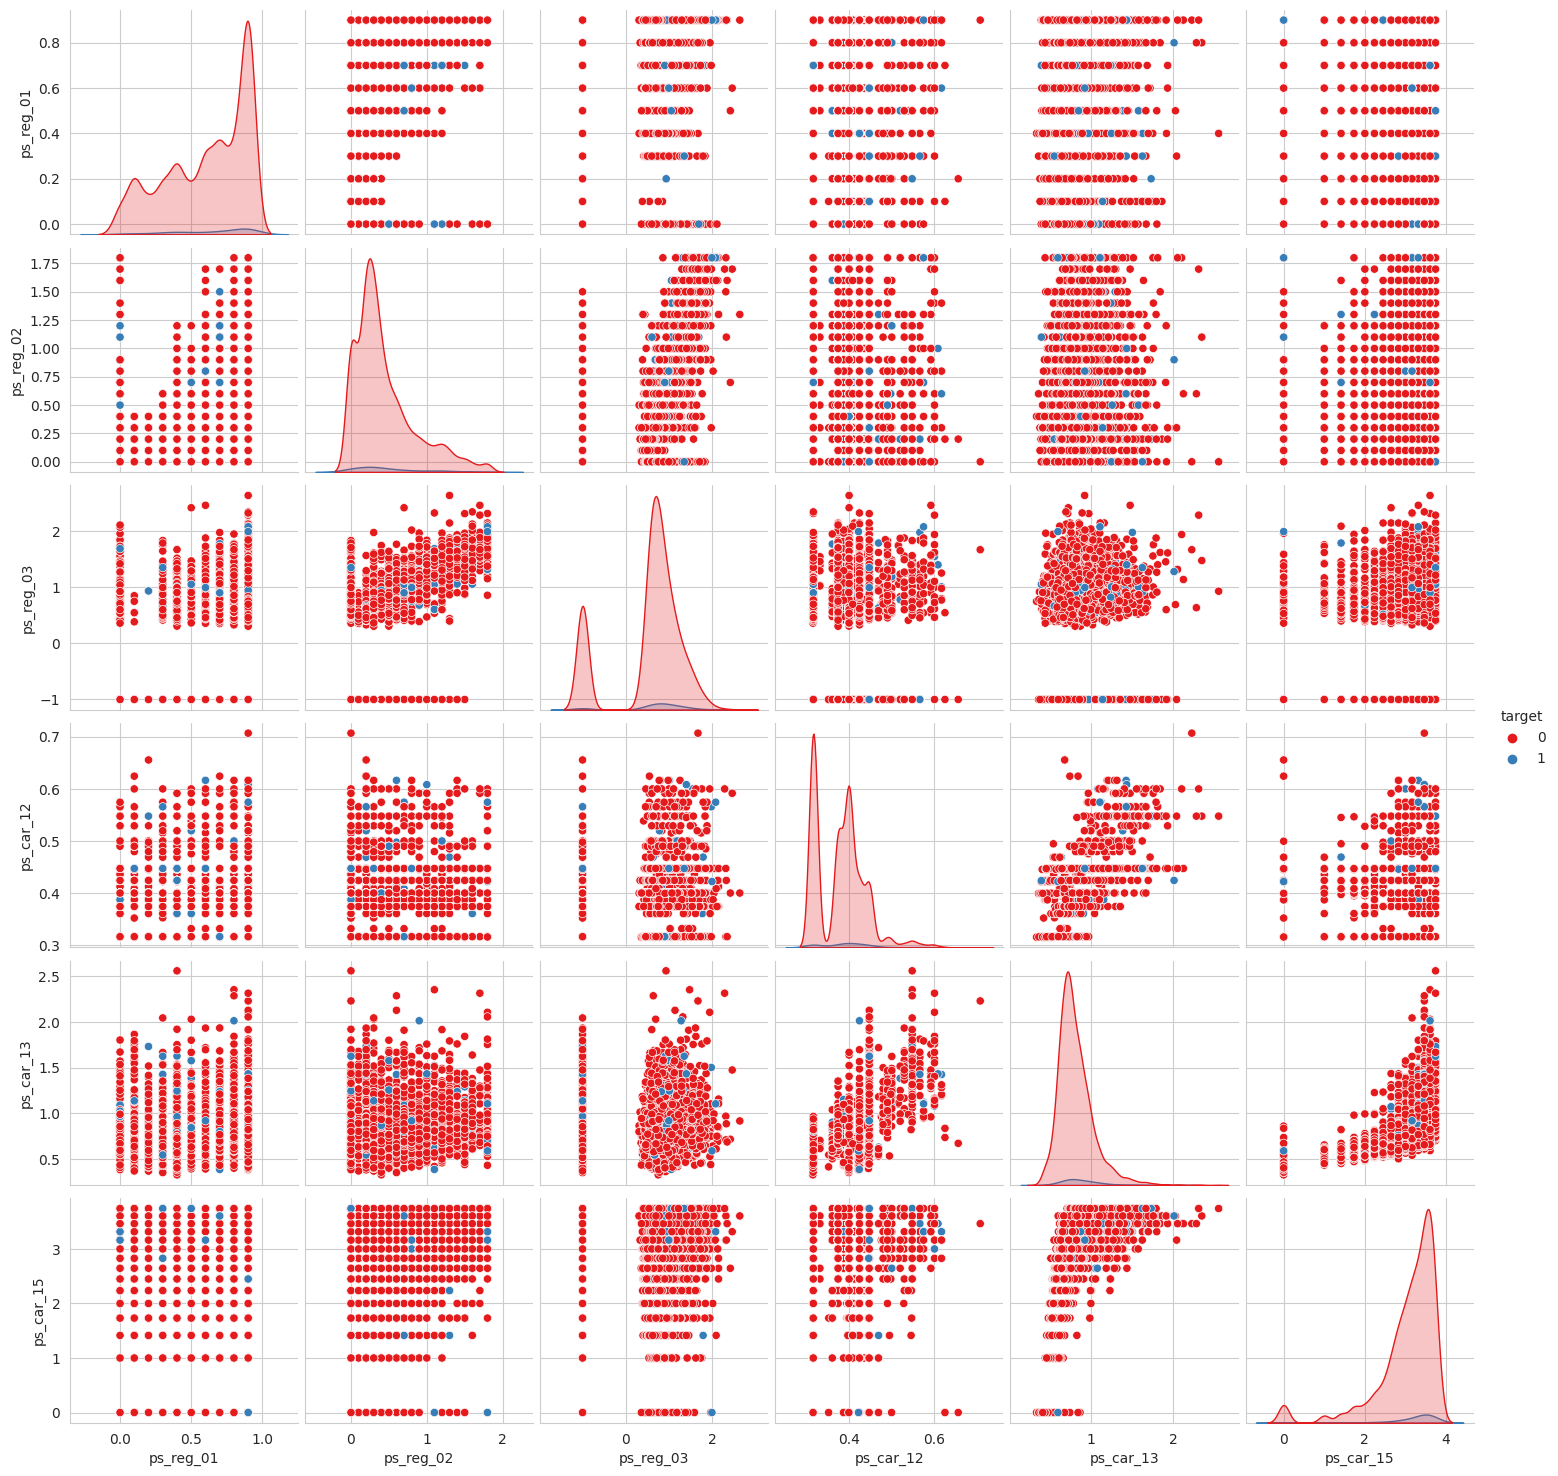

In [37]:
sample = trainset.sample(frac = 0.01)
var = ["ps_reg_01", "ps_reg_02", "ps_reg_03", "ps_car_12", "ps_car_13", "ps_car_15", "target"]
sample = sample[var]
sns.pairplot(sample, hue = 'target', palette = "Set1", diag_kind = "kde")
plt.show()

pairplot은 원하는데로 잘 안나오는데 실전에서 못쓸듯?

In [38]:
v = metadata[(metadata.type == "binary") & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


plt.xticks() 함수는 현재 x축의 눈금들의 위치(locs)와 라벨(labels)을 반환합니다. 이를 변수로 저장하여 라벨의 텍스트를 수정하거나, 눈금의 위치를 변경할 수 있습니다.

<ipython-input-39-7dd57012a021>:15: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend((p1,p2), ("Zero", "One"))


<Figure size 640x480 with 0 Axes>

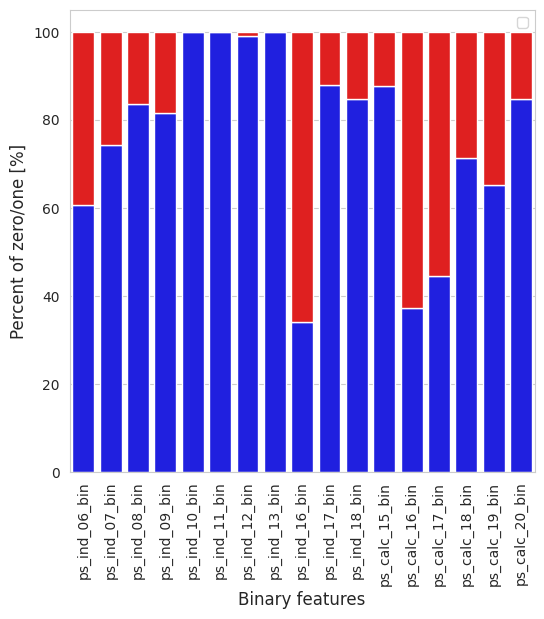

In [39]:
bin_col = [col for col in trainset.columns if "_bin" in col]
zero_list = []
one_list = []
for col in bin_col:
  zero_list.append((trainset[col] == 0).sum()/trainset.shape[0] * 100)
  one_list.append((trainset[col] == 1).sum()/trainset.shape[0] * 100)
plt.figure()
fig, ax = plt.subplots(figsize = (6,6))
p1 = sns.barplot(ax= ax, x= bin_col, y = zero_list, color = "blue")
p2 = sns.barplot(ax= ax, x= bin_col , y = one_list, bottom = zero_list, color = "red")
plt.ylabel("Percent of zero/one [%]", fontsize = 12)
plt.xlabel("Binary features", fontsize = 12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90) #라벨 회전
plt.legend((p1,p2), ("Zero", "One"))
plt.show()

왜 필사 내용과 다르게 나오지... 2회독 때 한번 더 확인해보자.

<ipython-input-40-08b26c6c9b19>:14: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
<ipython-input-40-08b26c6c9b19>:15: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t0[feature], bw = 0.5, label = "target = 0")
<ipython-input-40-08b26c6c9b19>:14: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
<ipython-input-40-08b26c6c9b19>:1

<Figure size 640x480 with 0 Axes>

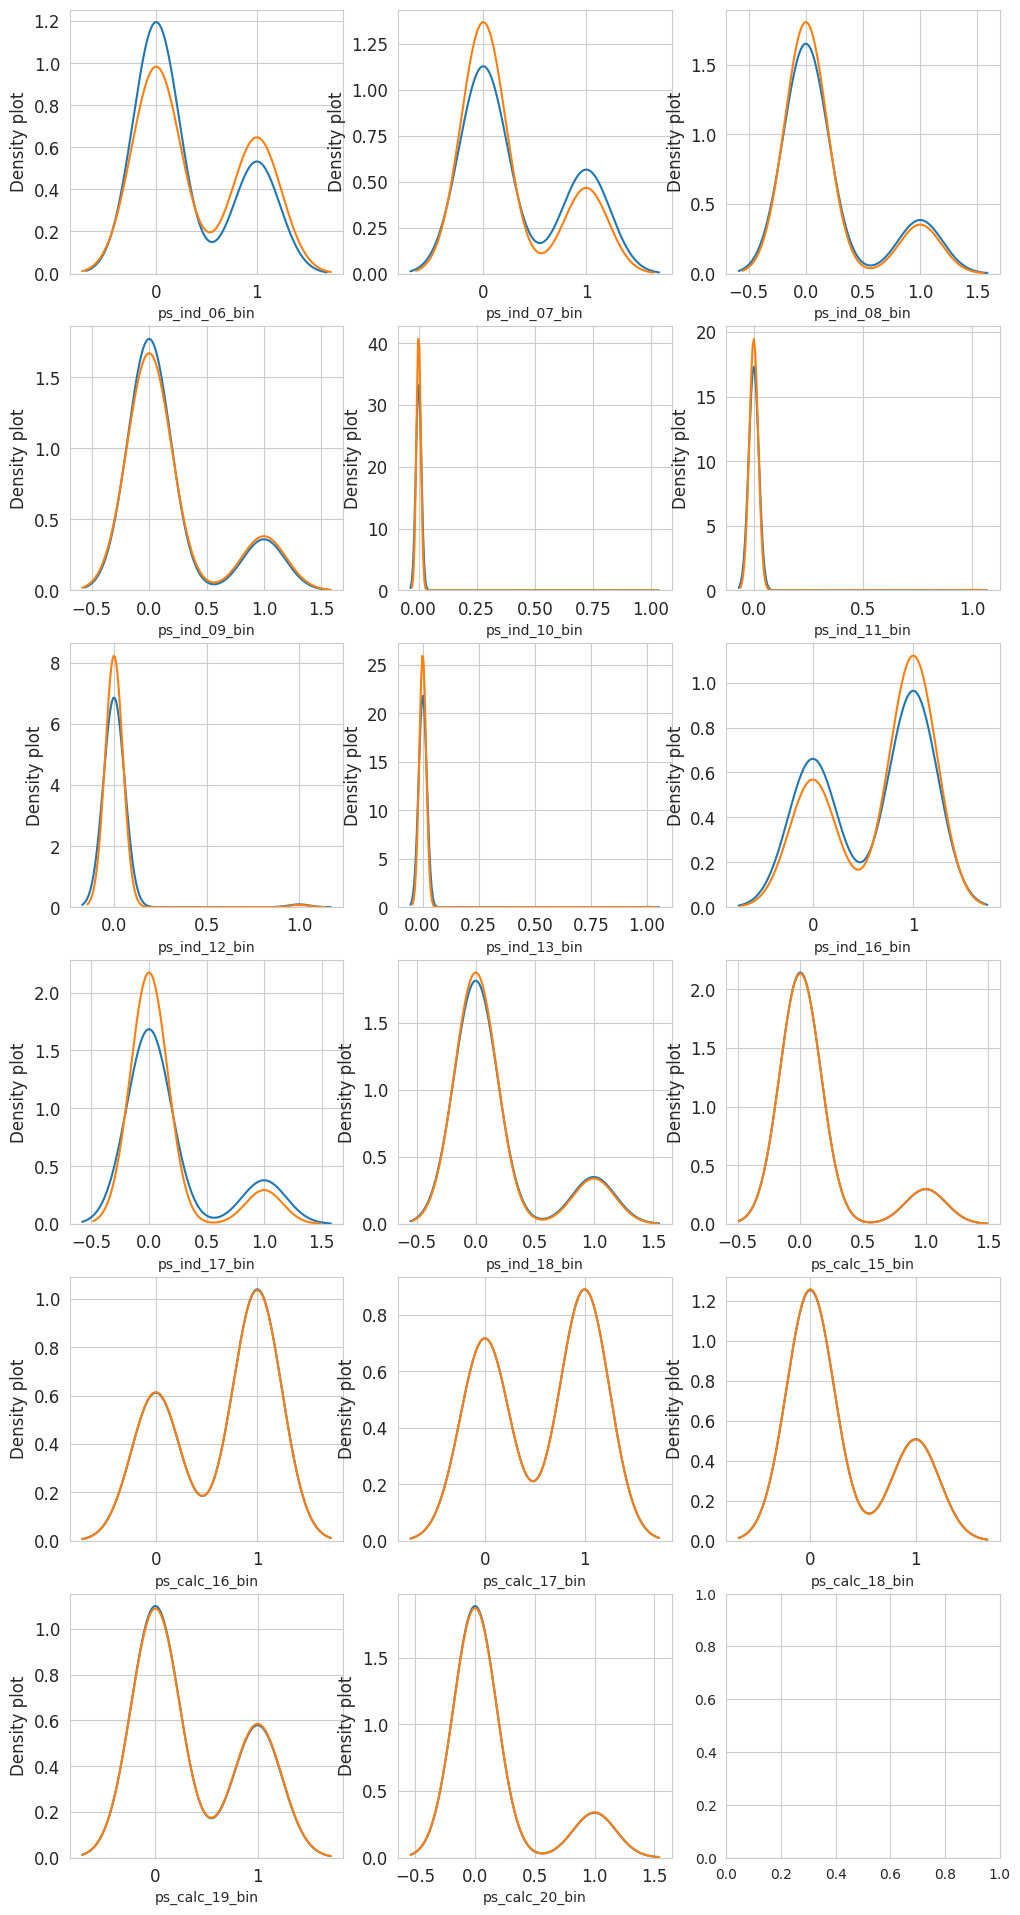

In [40]:
var = metadata[(metadata.type == "binary") & (metadata.preserve)].index
var = [col for col in trainset.columns if "_bin" in col]
i = 0
t1 = trainset.loc[trainset["target"] !=0]
t0 = trainset.loc[trainset["target"] ==0]

sns.set_style('whitegrid')
plt.figure()
flt, ax = plt.subplots(6,3, figsize = (12,24))

for feature in var:
  i+=1
  plt.subplot(6,3,i)
  sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
  sns.kdeplot(t0[feature], bw = 0.5, label = "target = 0")
  plt.ylabel("Density plot", fontsize =12)
  locs, labels = plt.xticks()
  plt.tick_params(axis = "both", which = "major", labelsize = 12)
plt.show()

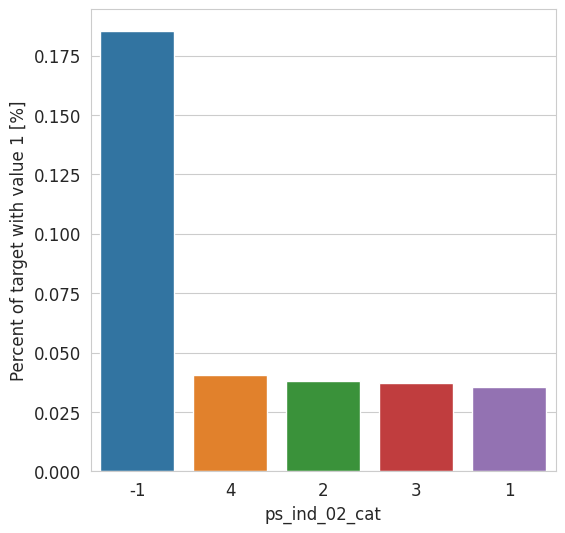

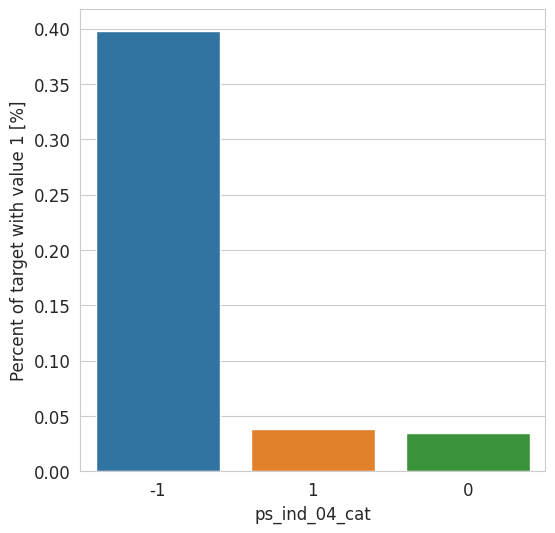

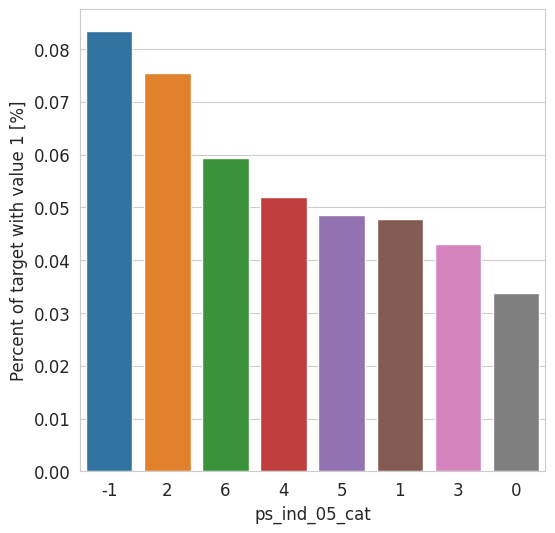

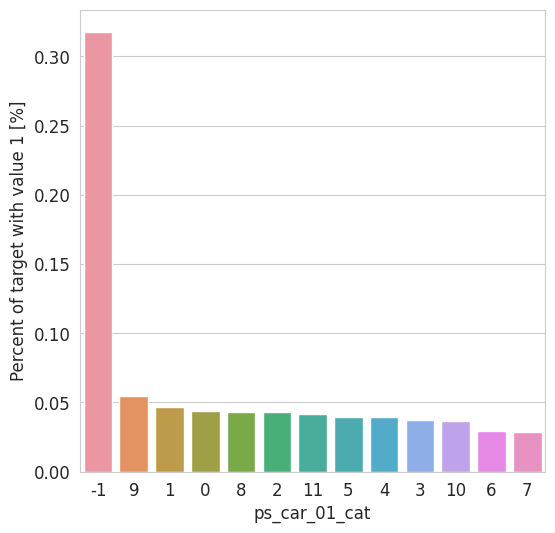

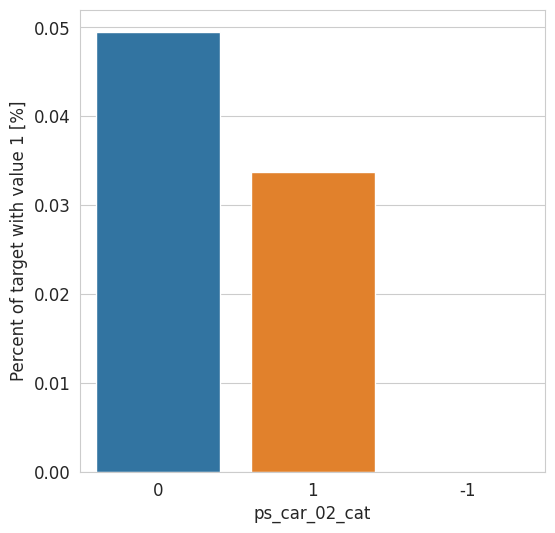

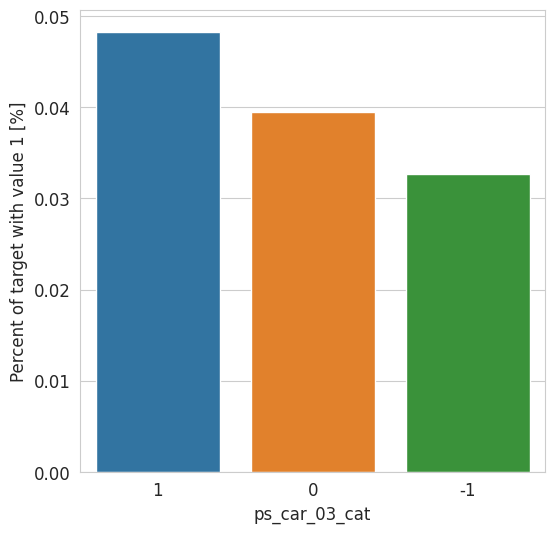

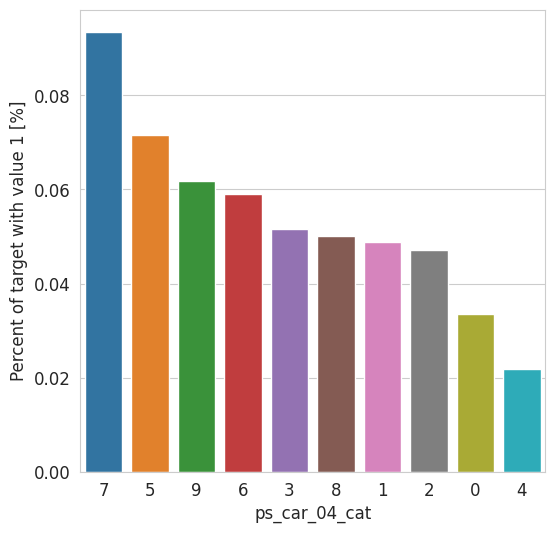

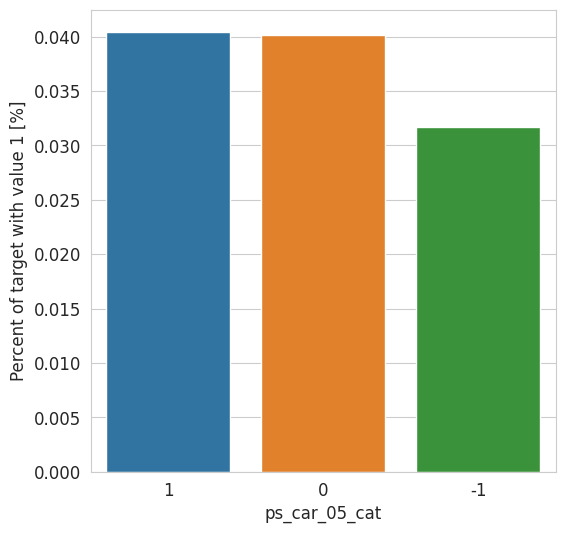

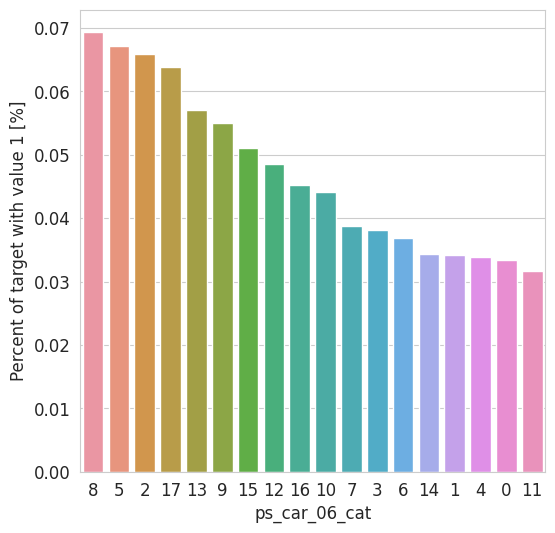

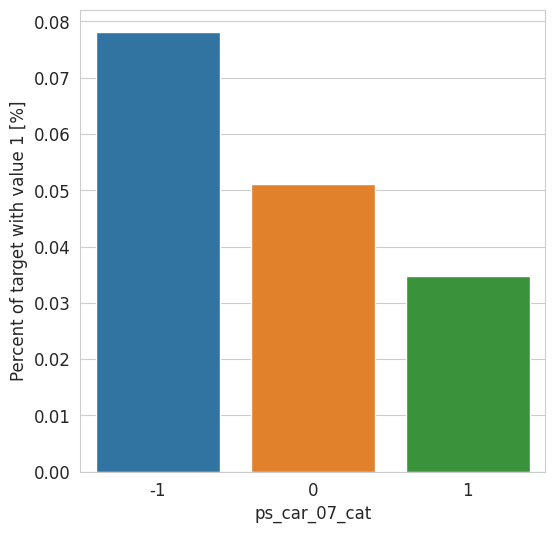

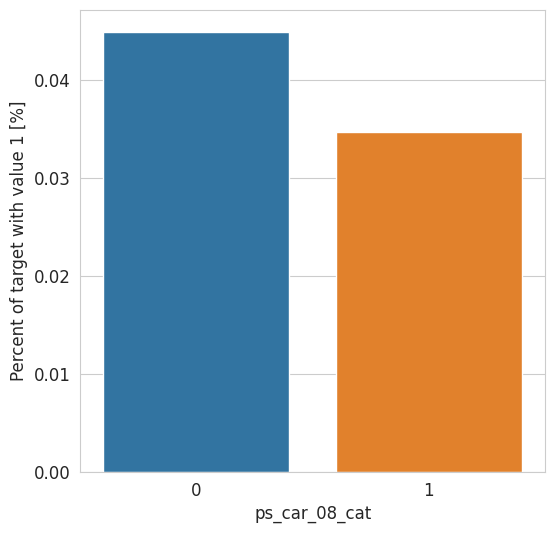

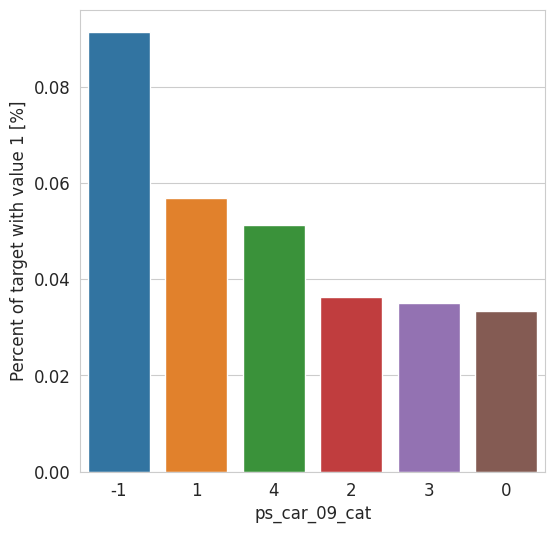

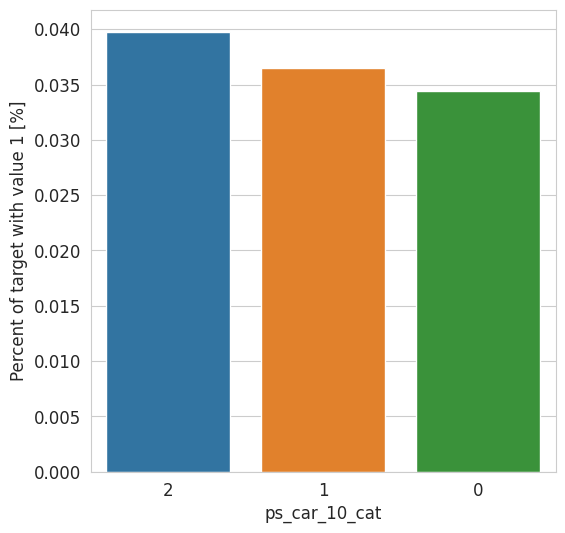

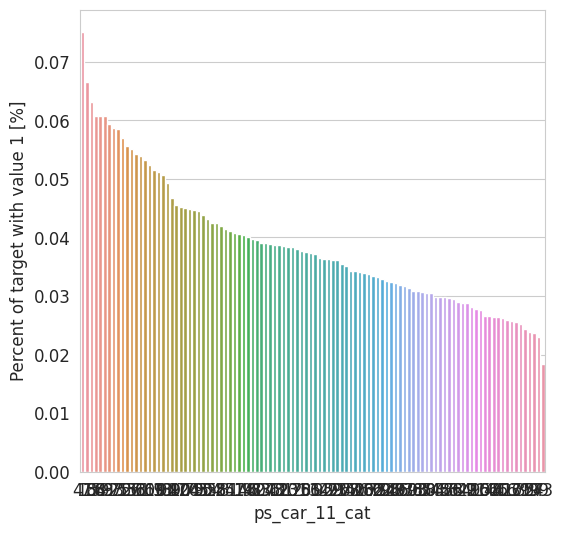

In [41]:
var = metadata[(metadata.type == "categorical") & (metadata.preserve)].index

for feature in var:
  fig, ax = plt.subplots(figsize = (6,6))

  cat_perc = trainset[[feature, "target"]].groupby([feature], as_index = False).mean()
  cat_perc.sort_values(by="target", ascending = False, inplace = True)

  sns.barplot(ax=ax, x= feature, y = "target", data = cat_perc, order=cat_perc[feature])
  plt.ylabel("Percent of target with value 1 [%]", fontsize = 12)
  plt.xlabel(feature, fontsize = 12)
  plt.tick_params(axis = "both", which = "major", labelsize = 12)
  plt.show()

<ipython-input-42-8523289552c8>:13: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t1[feature], bw = 0.5, label = "target = 1")
<ipython-input-42-8523289552c8>:14: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t0[feature], bw = 0.5, label = "target = 0")
<ipython-input-42-8523289552c8>:13: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t1[feature], bw = 0.5, label = "target = 1")
<ipython-input-42-8523289

<Figure size 640x480 with 0 Axes>

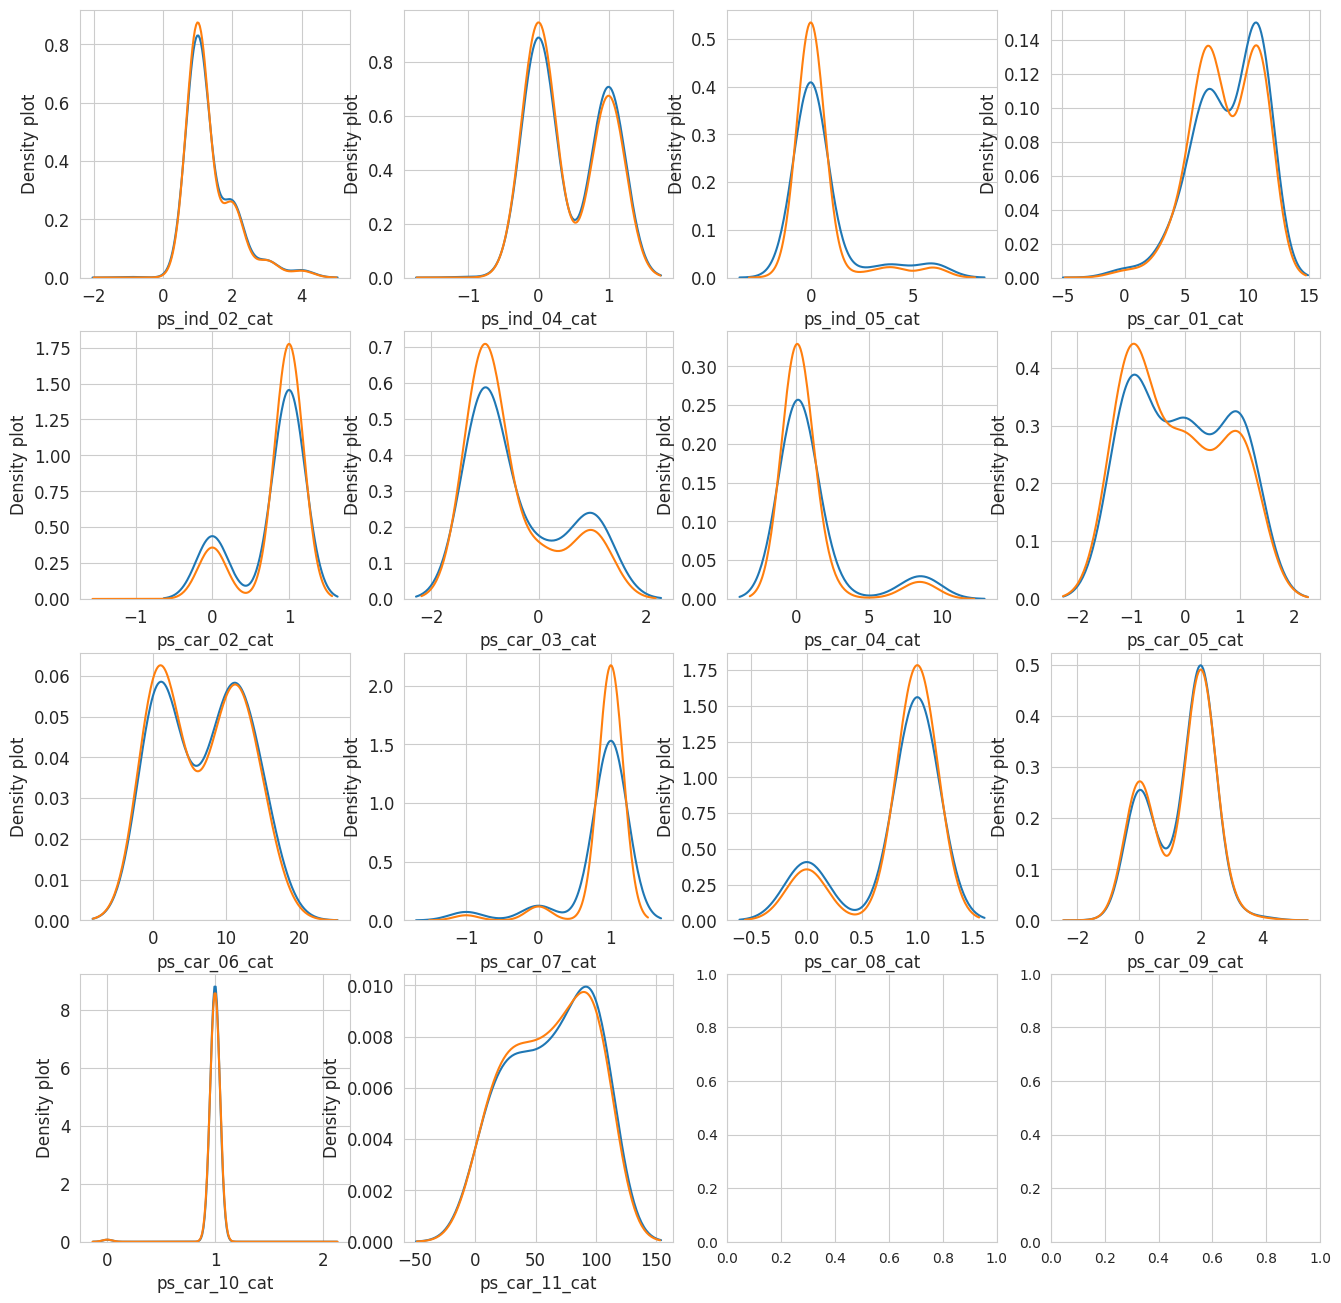

In [42]:
var = metadata[(metadata.type == "categorical") & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset["target"] != 0]
t0 = trainset.loc[trainset["target"] == 0]

sns.set_style("whitegrid")
plt.figure()
fig, ax = plt.subplots(4,4, figsize = (16,16))

for feature in var:
  i+=1
  plt.subplot(4,4,i)
  sns.kdeplot(t1[feature], bw = 0.5, label = "target = 1")
  sns.kdeplot(t0[feature], bw = 0.5, label = "target = 0")
  plt.ylabel("Density plot", fontsize = 12)
  plt.xlabel(feature, fontsize= 12)
  locs, labels = plt.xticks()
  plt.tick_params(axis = "both", which = "major", labelsize = 12)
plt.show();

<ipython-input-44-89b034608834>:11: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(trainset[feature], bw = 0.5, label = "train")
<ipython-input-44-89b034608834>:12: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(testset[feature], bw = 0.5, label = "test")
<ipython-input-44-89b034608834>:11: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(trainset[feature], bw = 0.5, label = "train")
<ipython-input-44-89b034

<Figure size 640x480 with 0 Axes>

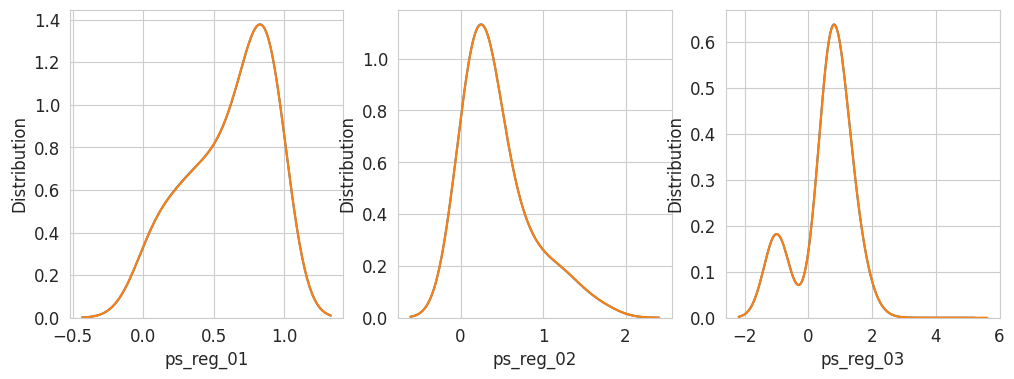

In [44]:
var = metadata[(metadata.category == "registration") & (metadata.preserve)].index

sns.set_style('whitegrid')

plt.figure()
fig, ax= plt.subplots(1,3, figsize = (12,4))
i = 0
for feature in var:
  i +=1
  plt.subplot(1,3,i)
  sns.kdeplot(trainset[feature], bw = 0.5, label = "train")
  sns.kdeplot(testset[feature], bw = 0.5, label = "test")
  plt.ylabel("Distribution", fontsize = 12)
  plt.xlabel(feature, fontsize = 12)
  locs, labels = plt.xticks()
  plt.tick_params(axis = "both", which = "major", labelsize = 12)

plt.show();

<ipython-input-46-75b00d5055ea>:11: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(trainset[feature], bw = 0.5, label = "train")
<ipython-input-46-75b00d5055ea>:12: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(testset[feature], bw = 0.5, label ="test")
<ipython-input-46-75b00d5055ea>:11: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(trainset[feature], bw = 0.5, label = "train")
<ipython-input-46-75b00d5

<Figure size 640x480 with 0 Axes>

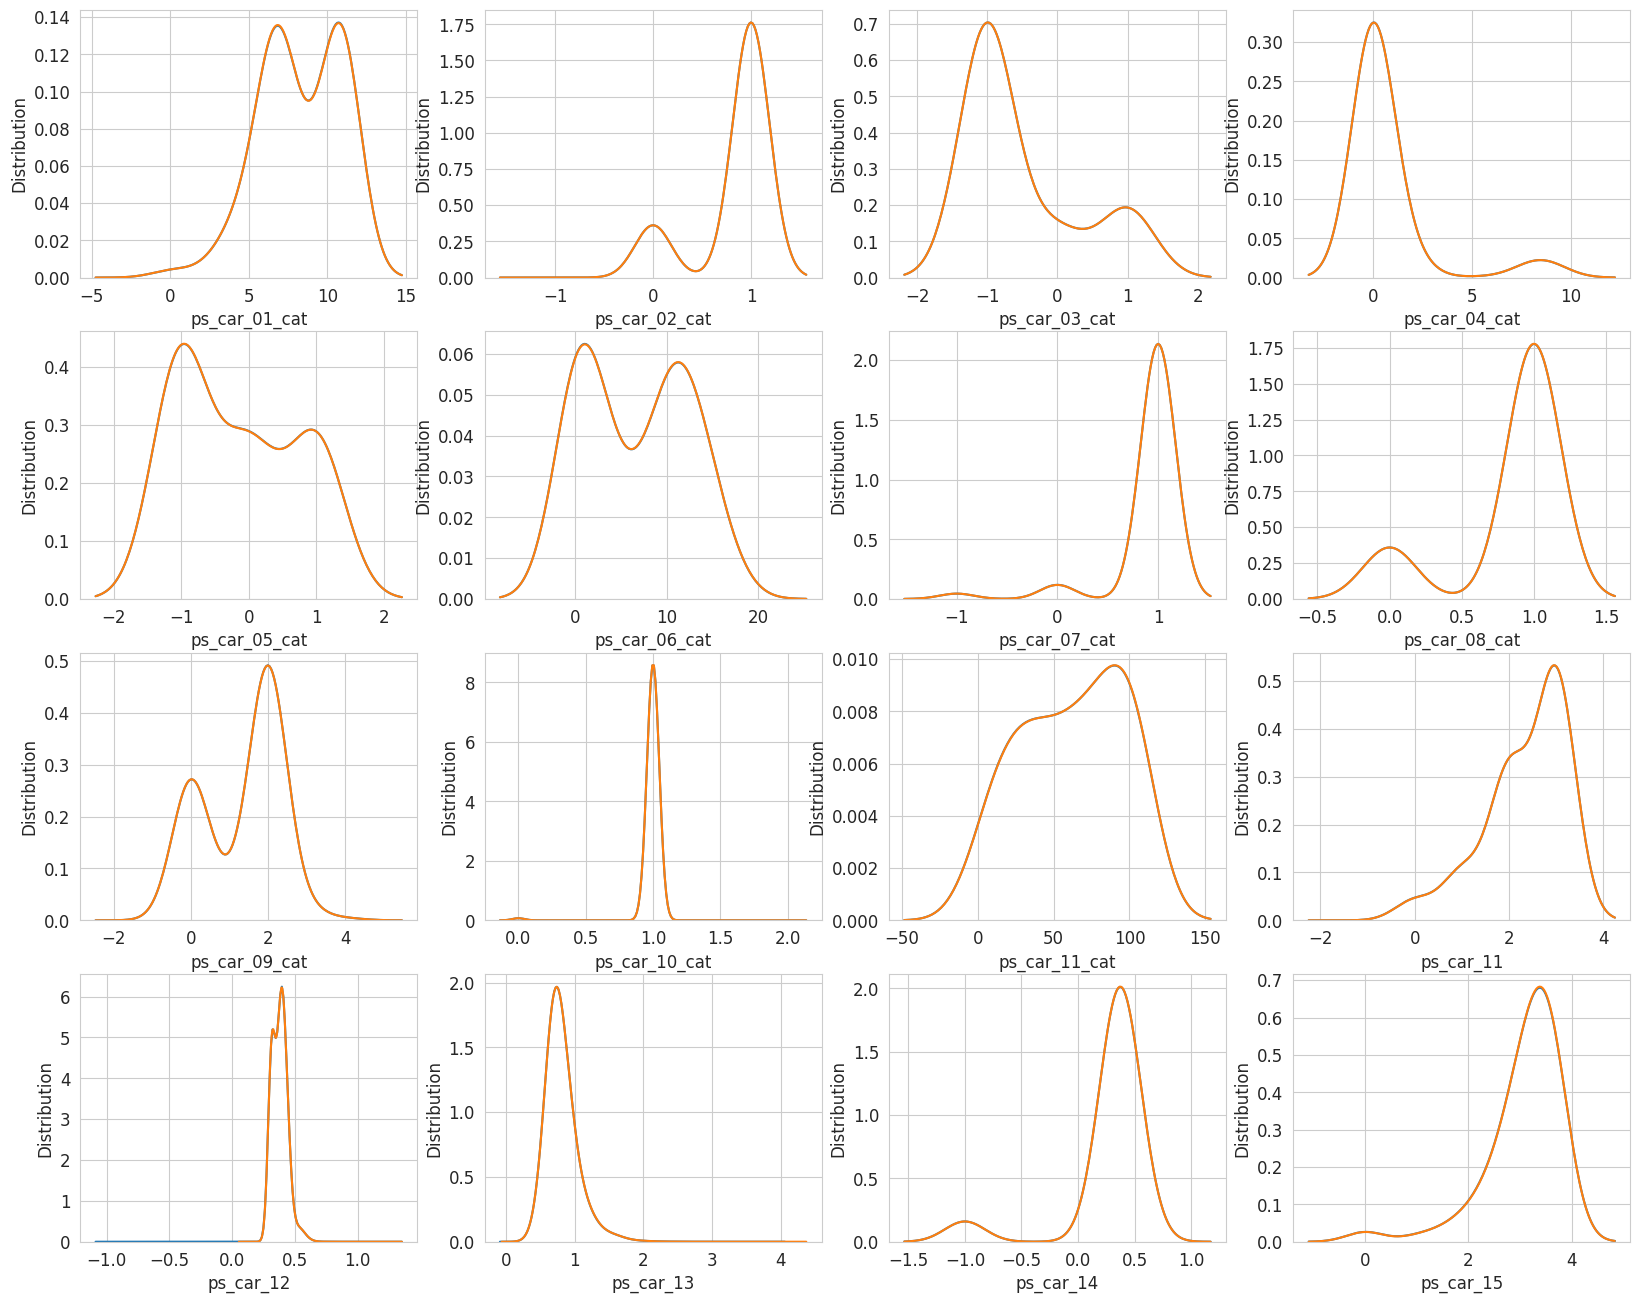

In [46]:
var = metadata[(metadata.category == "car") & (metadata.preserve)].index

sns.set_style("whitegrid")

plt.figure()
fig, ax = plt.subplots(4,4, figsize = (20,16))
i = 0
for feature in var:
  i+=1
  plt.subplot(4,4,i)
  sns.kdeplot(trainset[feature], bw = 0.5, label = "train")
  sns.kdeplot(testset[feature], bw = 0.5, label ="test")
  plt.ylabel("Distribution", fontsize= 12)
  plt.xlabel(feature, fontsize= 12)
  locs, labels = plt.xticks()
  plt.tick_params(axis = "both", which = "major", labelsize = 12)

plt.show();

In [ ]:
var = metadata[(metadata.category == "indivisual") & (metadata.preserve)].index

sns.set_style("whitegrid")

plt.figure()
fig, ax = plt.subplots(4,4, figsize = (20,16))
i = 0
for feature in var:
  i+=1
  plt.subplot(5,4,i)
  sns.kdeplot(trainset[feature], bw = 0.5, label = "train")
  sns.kdeplot(testset[feature], bw = 0.5, label ="test")
  plt.ylabel("Distribution", fontsize= 12)
  plt.xlabel(feature, fontsize= 12)
  locs, labels = plt.xticks()
  plt.tick_params(axis = "both", which = "major", labelsize = 12)

plt.show();

<ipython-input-47-6cdb9b8bfd20>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i)
<ipython-input-47-6cdb9b8bfd20>:11: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(trainset[feature], bw = 0.5, label = "train")
<ipython-input-47-6cdb9b8bfd20>:12: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(testset[feature], bw = 0.5, label ="test")
<ipython-input-47-6cdb9b8bfd20>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6

ValueError: ignored

<Figure size 640x480 with 0 Axes>

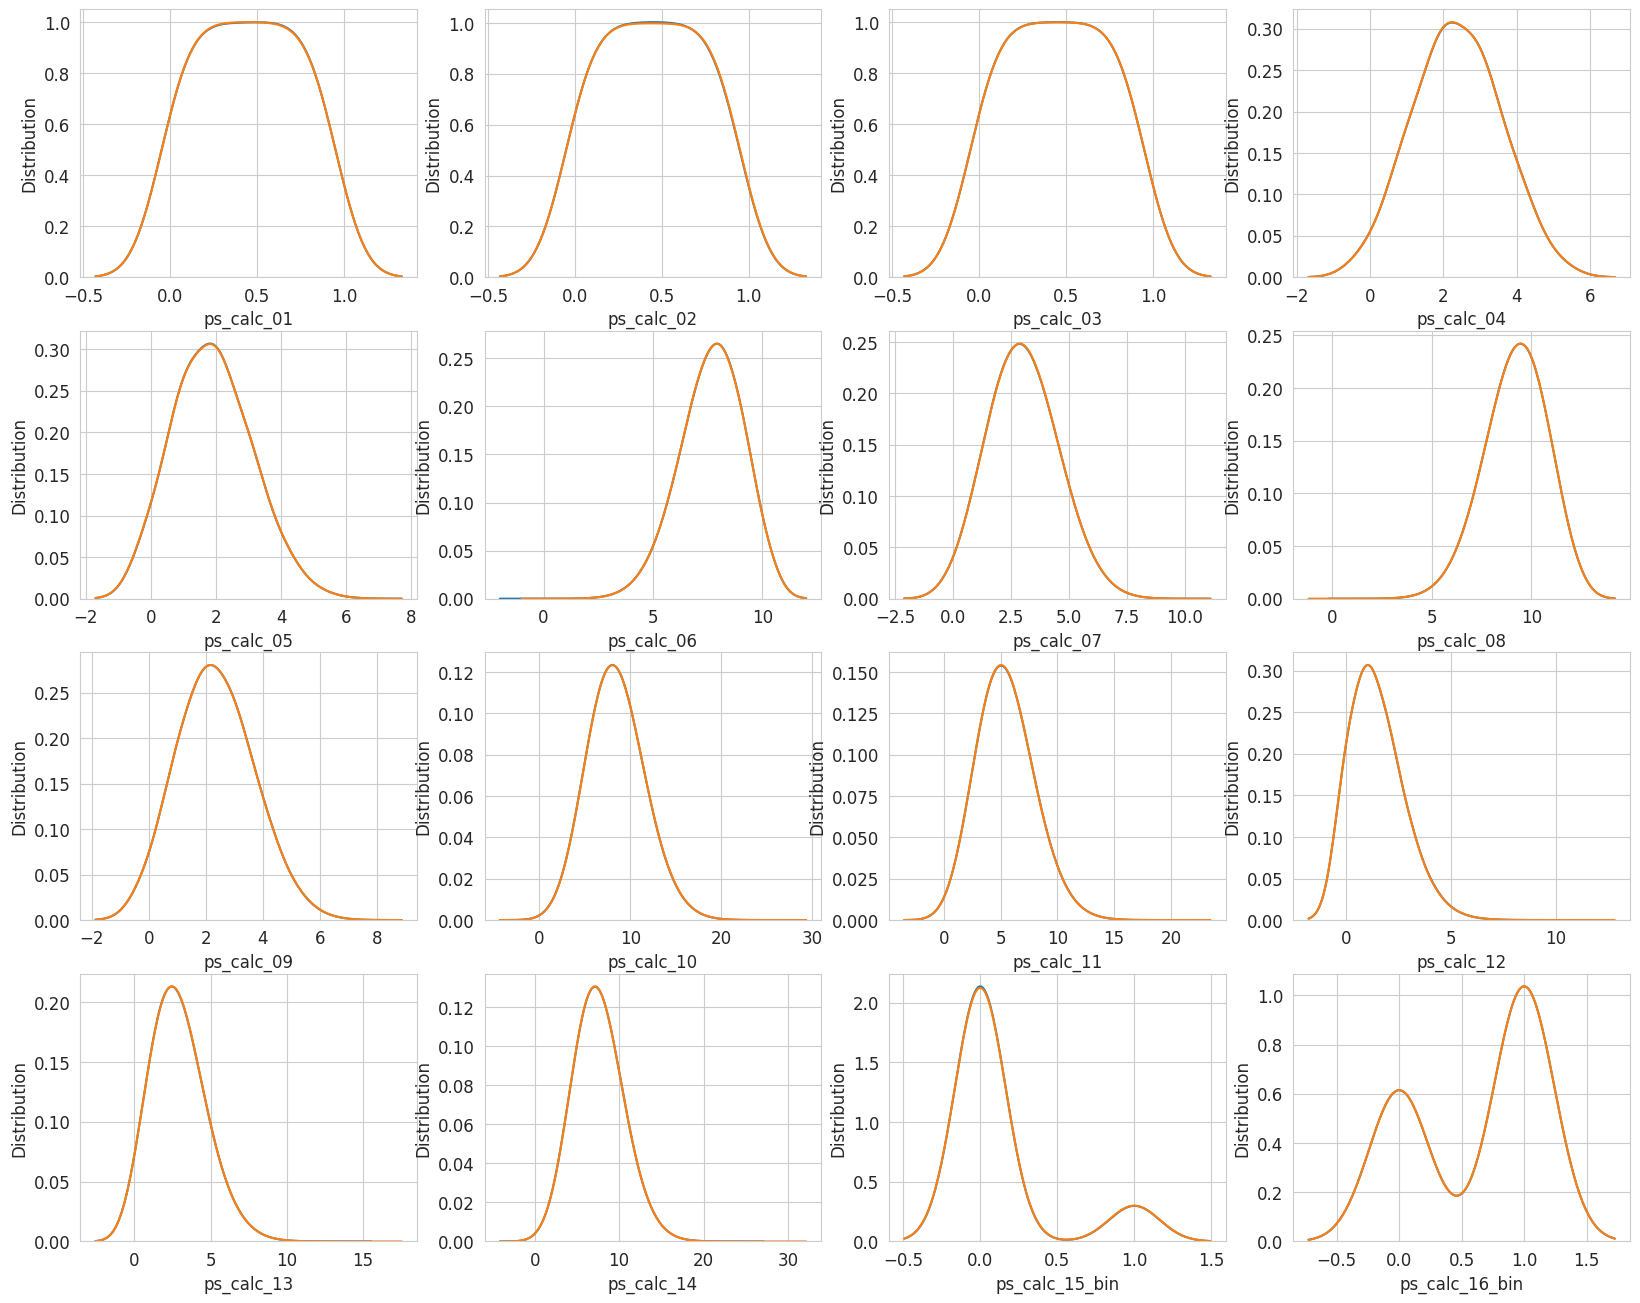

In [47]:
var = metadata[(metadata.category == "calculated") & (metadata.preserve)].index

sns.set_style("whitegrid")

plt.figure()
fig, ax = plt.subplots(5,4, figsize = (20,16))
i = 0
for feature in var:
  i+=1
  plt.subplot(4,4,i)
  sns.kdeplot(trainset[feature], bw = 0.5, label = "train")
  sns.kdeplot(testset[feature], bw = 0.5, label ="test")
  plt.ylabel("Distribution", fontsize= 12)
  plt.xlabel(feature, fontsize= 12)
  locs, labels = plt.xticks()
  plt.tick_params(axis = "both", which = "major", labelsize = 12)

plt.show();

In [49]:
vars_with_missing = []

for feature in trainset.columns:
  missings = trainset[trainset[feature] == -1][feature].count()
  if missings > 0:
    vars_with_missing.append(feature)
    missings_perc = missings/trainset.shape[0]
    print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


In [51]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis = 1)
testset = testset.drop(col_to_drop, axis= 1)

In [52]:
vars_to_drop = ["ps_car_03_cat", "ps_car_05_cat"]
trainset.drop(vars_to_drop, inplace = True, axis = 1)
testset.drop(vars_to_drop, inplace = True, axis = 1)
metadata.loc[(vars_to_drop), "keep"] =False

In [53]:
def add_noise(series, noise_level):
  return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series = None,
                  tst_series = None,
                  target = None,
                  min_samples_leaf = 1,
                  smoothing = 1,
                  noise_level = 0):
  assert len(trn_series) == len(target)
  assert trn_series.name == tst_series.name
  temp = pd.concat([trn_series, target], axis = 1)
  averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
  # Compute smoothing
  smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
  prior = target.mean()
  averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
  averages.drop(["mean", "count"], axis=1, inplace=True)

  ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
  ft_trn_series.index = trn_series.index 
  ft_tst_series = pd.merge(
      tst_series.to_frame(tst_series.name),
      averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
      on=tst_series.name,
      how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

  ft_tst_series.index = tst_series.index
  return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

  

In [54]:
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"], 
                             testset["ps_car_11_cat"], 
                             target=trainset.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat','keep'] = False  # Updating the metadata
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

In [67]:
desired_apriori = 0.10

idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

undersampled_idx = shuffle(idx_0, random_state = 314, n_samples = undersampled_nb_0)

#target 0 인거랑 1인거의 인덱스를 합치고
idx_list = list(undersampled_idx) + list(idx_1)
print("idx_list : ", idx_list[:10])

#해당하는 인덱스에 해당하는 데이터만 trainset으로 만든다.
trainset = trainset.loc[idx_list].reset_index(drop= True)

Rate to undersample records with target=0: 1.0
Number of records with target=0 after undersampling: 195246
idx_list :  [161281, 161646, 37116, 86468, 62519, 157938, 82844, 164421, 42880, 69784]


In [68]:
undersampled_idx

Int64Index([161281, 161646,  37116,  86468,  62519, 157938,  82844, 164421,
             42880,  69784,
            ...
            157922, 138759, 187120,   9678,   1066, 142166, 174003, 175817,
             75373,  14856],
           dtype='int64', length=195246)

In [69]:
trainset.loc[100000
]

id                  178950.000000
target                   0.000000
ps_ind_01                7.000000
ps_ind_02_cat            1.000000
ps_ind_03                5.000000
ps_ind_04_cat            0.000000
ps_ind_05_cat            0.000000
ps_ind_06_bin            0.000000
ps_ind_07_bin            0.000000
ps_ind_08_bin            1.000000
ps_ind_09_bin            0.000000
ps_ind_10_bin            0.000000
ps_ind_11_bin            0.000000
ps_ind_12_bin            0.000000
ps_ind_13_bin            0.000000
ps_ind_14                0.000000
ps_ind_15               13.000000
ps_ind_16_bin            1.000000
ps_ind_17_bin            0.000000
ps_ind_18_bin            0.000000
ps_reg_01                0.800000
ps_reg_02                0.600000
ps_reg_03                0.742883
ps_car_01_cat           10.000000
ps_car_02_cat            0.000000
ps_car_04_cat            0.000000
ps_car_06_cat           10.000000
ps_car_07_cat            0.000000
ps_car_08_cat            1.000000
ps_car_09_cat 

In [70]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

In [71]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset,temp],axis=1)
    trainset = trainset.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset,temp],axis=1)
    testset = testset.drop([column],axis=1)

In [72]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target','id'], axis = 1)
testset = testset.drop(['id'], axis = 1)

In [73]:
print("Train dataset (rows, cols):",trainset.values.shape, "\nTest dataset (rows, cols):",testset.values.shape)

Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols): (892816, 91)


In [82]:
trainset.shape[0]

216940

In [83]:
trainset.shape[1]

91

In [84]:
trainset.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_car_11_cat_te,1.0,2.0,3.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,0.0,1.0,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,0.0,1.0,0,1,0.0,1.0,2.0,3.0,4.0,0,1,2
0,0,2,1,0,0,0,0,0,0,0,0,6,1,0,0,0.2,0.2,NaN,3.0,0.316228,0.676754,0.361525,3.162278,0.031177,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0
1,4,8,0,1,0,0,0,0,0,0,0,2,0,0,1,0.4,0.0,0.872496,2.0,0.547723,1.812256,0.532917,3.741657,0.074987,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0
2,1,6,0,0,1,0,0,0,0,0,0,9,0,1,0,0.9,0.7,1.276470,3.0,0.547723,1.178045,0.404351,3.000000,0.045766,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0
3,0,4,1,0,0,0,0,0,0,0,0,9,1,0,0,0.9,0.1,0.392906,3.0,0.400000,0.882497,0.342053,3.605551,0.037787,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
4,1,3,0,0,1,0,0,0,0,0,0,8,1,0,0,0.1,0.2,NaN,0.0,0.374166,0.781501,0.430116,3.605551,0.049081,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0


split() 함수는 k-fold로 데이터를 분할하는 함수입니다. 반환되는 folds는 (train_index, test_index)로 이루어진 k-fold 인덱스를 포함하는 리스트입니다.

In [76]:
class Ensemble(object):
  def __init__(self, n_splits, stacker, base_models):
    self.n_splits = n_splits
    self.stacker = stacker
    self.base_models = base_models

  def fit_predict(self, X, y, T):
    X = np.array(X)
    y = np.array(y)
    T = np.array(T)

    folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle = True, random_state = 314).split(X,y))

    S_train = np.zeros((X.shape[0], len(self.base_models)))
    S_test = np.zeros((T.shape[0], len(self.base_models)))
    for i, clf in enumerate(self.base_models):
      #흠...?
      S_test_i = np.zeros((T.shape[0], self.n_splits))

      for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]

        print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
        clf.fit(X_train, y_train)
        #결과 체크
        cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
        print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))

        #
        y_pred = clf.predict_proba(X_holdout)[:,1]                

        S_train[test_idx, i] = y_pred
        S_test_i[:, j] = clf.predict_proba(T)[:,1]
        S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

In [77]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

In [78]:
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)
       
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

In [79]:
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))  

In [80]:
y_prediction = stack.fit_predict(trainset, target_train, testset)

Base model 1: fit LGBMClassifier model | fold 1
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc-auc]: 0.63776 [gini]: 0.27552
Stacker score [gini]: 0.03205
